# <font color='darkblue'>Capstone Project : Quora Duplicate Question Pair Identification</font>

<hr style="border: 2px solid red" />

## Introduction
<p>Quora is an American Q&A website with a continually growing user generated collection of questions and answers. All the questions and answers are created, edited, and organized by the people who use it.</p>

<p>As per Kornél Csernai, a Machine Learning Platform Engineer at Quora : </p>

<p><i>“An important product principle for Quora is that there should be a single question page for each logically distinct question. As a simple example, the queries “What is the most populous state in the USA?” and “Which state in the United States has the most people?” should not exist separately on Quora because the intent behind both is identical. Having a canonical page for each logically distinct query makes knowledge-sharing more efficient in many ways: for example, knowledge seekers can access all the answers to a question in a single location, and writers can reach a larger readership than if that audience was divided amongst several pages.”</i><p>
    
<p>Duplicate questions are very common on Quora. Duplicate questions may prevent a user from seeing a high quality response that already exists and responders are unlikely to answer the same question twice. Identifying duplicate questions addresses these issues. It reduces the answering burden for responders and makes it possible to direct users to the best responses, improving the overall user experience.</p>

<p>Here are the 3 major advantages of solving this problem:<p>
Cheaper data storage.
Improved Customer Experience 
Re-use content.

## Dataset
The dataset that I plan to use is based on actual data from Quora and is available on Kaggle. There are over 400,000 lines of potential question duplicate pairs. Each line contains IDs for each question in the pair, the full text for each question, and a binary value that indicates whether the line truly contains a duplicate pair.
Here’s the complete list and description of the columns:
<table>
    <tr><td>Id          </td><td>the id for each question pair    </td></tr>
    <tr><td>Qid1        </td><td>the id for question 1 in the pair</td></tr>
    <tr><td>Qid2        </td><td>the id for question 2 in the pair</td></tr>
    <tr><td>Question1   </td><td>the full text for question1      </td></tr>
    <tr><td>Question2   </td><td>the full text for question2      </td></tr>
    <tr><td>Is_duplicate</td><td>yes(1) ; no(0)                   </td></tr>
</table>

## Goal
The goal is to use this dataset to train and test models of semantic equivalence. The machine learning model should be able to look at a set of two questions and determine if they have the same meaning.

<hr style="border: 2px solid red" />

# Exploratory Data Analysis

In [5]:
# Importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [37]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Loading the dataset
df = pd.read_csv("drive/My Drive/Colab Notebooks/CapstoneProject/train.csv")

In [39]:
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [40]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [42]:
#question1 has 1 null value 
#question2 has 2 null values
#Let's locate which question1 has a null value
df[df.question1.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [43]:
#The Null question1 has an qid1 = 493340. 
#Let's check if there is an instance of qid = 493340 is present anywhere in the dataset with a valid question attached to it.
df[(df.qid1 == 493340) | (df.qid2 == 493340)]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [0]:
#We cannot fill this null question1 with the correct question. It is better to delete the record.

In [45]:
#Let's check how many records are there where question2 is null
df[df.question2.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [46]:
#The 2 instances of Null question2 have ids 174364. 
#Let's check if there is an instance of qid = 174364 is present anywhere in the dataset with a valid question attached to it.
df[(df.qid1 == 174364) | (df.qid2 == 174364)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [0]:
#We cannot fill this null question1 with the correct question. It is better to delete the record.

In [0]:
#Deleting records with null in qid1 or qid2
df = df.dropna(subset=['question1','question2'])

In [49]:
#Verifying the deletes
df[(df.question1.isnull()) | (df.question2.isnull())]

,id,qid1,qid2,question1,question2,is_duplicate


In [50]:
#Let's check if there are any records where question1 == question2
df[df.question1 == df.question2]

,id,qid1,qid2,question1,question2,is_duplicate


In [51]:
#Let's check if a qid1, qid2 pair is repeated more than once
pair_count = df.groupby(['qid1','qid2']).size()
pair_count[pair_count > 1]

Series([], dtype: int64)

In [52]:
#The above code will not capture the scenario if qid1 and qid2 are interchanged. 
#Let's see if there cases such as qid1=N1/qid2=N2 and qid1=N2/qid2=N1.
list_of_qids_1_2 = (df['qid1'].astype(str) + '-' + df['qid2'].astype(str)).tolist() 
list_of_qids_2_1 = (df['qid2'].astype(str) + '-' + df['qid1'].astype(str)).tolist()
combined_list = pd.Series(list_of_qids_1_2 + list_of_qids_2_1)
result = combined_list.duplicated()
result[result == True]

Series([], dtype: bool)

In [53]:
#Let's check how many unique instances of qid1 are there.
len(df.qid1.unique())

290652

In [54]:
#Let's check how many unique instances of qid2 are there.
len(df.qid2.unique())

299362

In [0]:
#Based on the above queries, a question might be repeated in more than one pair.

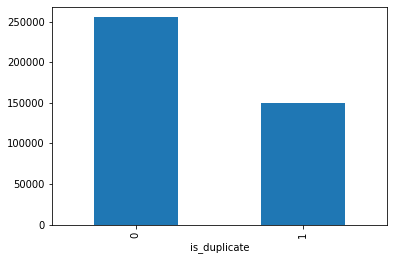

In [56]:
#Graph of duplicates vs non-duplicates
df.groupby("is_duplicate")['id'].count().plot.bar()

In [57]:
#Average number of words per question
print('Mean question1 : ', df['question1'].str.split().apply(len).mean(), ' words')
print('Median question1 : ', df['question1'].str.split().apply(len).median(), ' words')
print('Mean question1 : ', df['question1'].str.split().apply(len).mean(), ' words')
print('Median question1 : ', df['question1'].str.split().apply(len).median(), ' words')

Mean question1 :  10.942256367382576  words
Median question1 :  10.0  words
Mean question1 :  10.942256367382576  words
Median question1 :  10.0  words


In [58]:
print('Not Duplicate Question Pairs (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\nDuplicate Question Pairs (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Not Duplicate Question Pairs (is_duplicate = 0):
   63.08%

Duplicate Question Pairs (is_duplicate = 1):
   36.92%


In [0]:
df_not_duplicate = df[df.is_duplicate == 0].sample(n = 5000)
df_duplicate = df[df.is_duplicate == 1].sample(n = 5000)
df = df_not_duplicate.append(df_duplicate)

In [60]:
print('Not Duplicate Question Pairs (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\nDuplicate Question Pairs (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Not Duplicate Question Pairs (is_duplicate = 0):
   50.0%

Duplicate Question Pairs (is_duplicate = 1):
   50.0%


# Processing Text Data

  #### Dropping Null Values

In [0]:
#Deleting records with null in qid1 or qid2
df = df.dropna(subset=['question1','question2'])

#### Convert question1 and question2 to lower case

In [62]:
df['question1'] = df['question1'].str.lower()
df['question2'] = df['question2'].str.lower()
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
160643,160643,250488,250489,is it okay to have nocturnal emissions when sl...,why do i need to sleep 10 hours to be okay?,0
63247,63247,110101,110102,i'm 13 years old and just found out i'm pregna...,i just found out that my ex got engaged. i'm n...,0
217878,217878,324344,324345,can the average listener discern the differenc...,audiophiles: does listening to mp3 at 320kbps ...,0
152351,152351,239371,239372,who is pawan tiwari?,who is pawan?,0
43267,43267,77849,77850,how do dermatologist remove skin tags?,can a wart remover remove skin tags?,0


#### Removing STOP Words
However, for my dataset I noticed that removing stop words removing critical context words without the which the questions had no meaning. Moreover, many questions were just left with 2-3 words and the machine algorithm accuracies were reduced. Hence, this region is commented out.

In [0]:
# # Remove STOP words
# import nltk
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english')) 

# def remove_stopwords(x):
#   word_tokens = word_tokenize(x)   
#   filtered_sentence = [w for w in word_tokens if not w in stop_words] 
#   return ' '.join(word for word in filtered_sentence)

# df['question1'] = df['question1'].apply(remove_stopwords)
# df['question2'] = df['question2'].apply(remove_stopwords)

In [64]:
df['question2']

160643          why do i need to sleep 10 hours to be okay?
63247     i just found out that my ex got engaged. i'm n...
217878    audiophiles: does listening to mp3 at 320kbps ...
152351                                        who is pawan?
43267                  can a wart remover remove skin tags?
                                ...                        
118202                            how do i motivate myself?
22075                               how do learn telepathy?
337839                       how can i improve my speaking?
389092    which would be better for gaming: i3 5005u wit...
51798                           which tv show is best ever?
Name: question2, Length: 10000, dtype: object

#### Word Replacements

In [0]:
def word_replace(x):
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                            .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                            .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                            .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                            .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                            .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                            .replace("€", " euro ").replace("'ll", " will")
  return x

df["question1"] = df["question1"].fillna("").apply(word_replace)
df["question2"] = df["question2"].fillna("").apply(word_replace)

#### Remove punctuation

In [66]:
df['question1'] = df['question1'].str.replace(r'[^\w\s]+', '')
df['question2'] = df['question2'].str.replace(r'[^\w\s]+', '')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
160643,160643,250488,250489,is it okay to have nocturnal emissions when sl...,why do i need to sleep 10 hours to be okay,0
63247,63247,110101,110102,i am 13 years old and just found out i am preg...,i just found out that my ex got engaged i am n...,0
217878,217878,324344,324345,can the average listener discern the differenc...,audiophiles does listening to mp3 at 320kbps i...,0
152351,152351,239371,239372,who is pawan tiwari,who is pawan,0
43267,43267,77849,77850,how do dermatologist remove skin tags,can a wart remover remove skin tags,0


#### Lemmatization

In [67]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer() 
  
df['question1'] = df['question1'].apply(lambda x : " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
df['question2'] = df['question2'].apply(lambda x : " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,qid1,qid2,question1,question2,is_duplicate
160643,160643,250488,250489,is it okay to have nocturnal emission when sle...,why do i need to sleep 10 hour to be okay,0
63247,63247,110101,110102,i am 13 year old and just found out i am pregn...,i just found out that my ex got engaged i am n...,0
217878,217878,324344,324345,can the average listener discern the differenc...,audiophiles doe listening to mp3 at 320kbps is...,0
152351,152351,239371,239372,who is pawan tiwari,who is pawan,0
43267,43267,77849,77850,how do dermatologist remove skin tag,can a wart remover remove skin tag,0


# Feature Extraction

#### Calculate words_diff_q1_q2  = difference of the word counts between question1 and question2

In [0]:
df['words_diff_q1_q2'] = abs(df['question1'].apply(lambda row: len(row.split(" "))) - df['question2'].apply(lambda row: len(row.split(" "))))

#### Calculate word_common = count of unique words in question1 and question2

In [0]:
def normalized_word_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)
    
df['word_common'] = df.apply(normalized_word_common, axis=1)

#### Calculate word_total = total number of words in Question 1 + total number of words in Question 2

In [0]:
def normalized_word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return (len(w1) + len(w2))
    
df['word_total'] = df.apply(normalized_word_total, axis=1)    

#### Calculate word_share = word_common / word_total

In [0]:
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

#### Vectorizing question1 and question2 and doing distance matrix computations

In [72]:
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

def convert(lst): 
    return (lst[0].split())

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

q1_q2_vectors = {}

def get_q1_q2_vectors(row):

      if row['id'] not in q1_q2_vectors:
          
          vocab = set()
          
          q1_list = []
          # print(type(q1_list))
          q1_list.append(row['question1'].replace("\n", " "))          
          vocab = vocab.union(set(convert(q1_list)))

          q2_list = []
          q2_list.append(row['question2'].replace("\n", " "))
          vocab = vocab.union(set(convert(q2_list)))          

          # integer encode sequences of words
          tokenizer = Tokenizer(filters=[])
          tokenizer.fit_on_texts(vocab)

          q1_seq = tokenizer.texts_to_sequences(q1_list)
          q2_seq = tokenizer.texts_to_sequences(q2_list)

          PAD_LENGTH = len(q1_seq[0]) + len(q2_seq[0])
          q1_seq_padded = pad_sequences(q1_seq, maxlen=PAD_LENGTH)
          q2_seq_padded = pad_sequences(q2_seq, maxlen=PAD_LENGTH)

          q1_seq_sorted = np.sort(q1_seq_padded[0])
          q2_seq_sorted = np.sort(q2_seq_padded[0])

          q1_q2_list = []
          q1_q2_list.append(q1_seq_sorted)
          q1_q2_list.append(q2_seq_sorted)

          q1_q2_vectors[row['id']] = q1_q2_list

      return q1_q2_vectors[row['id']][0], q1_q2_vectors[row['id']][1]

def get_cosine_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return cosine(q1_q2_vectors[0], q1_q2_vectors[1])

def get_cityblock_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return cityblock(q1_q2_vectors[0], q1_q2_vectors[1])

def get_jaccard_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return jaccard(q1_q2_vectors[0], q1_q2_vectors[1])

def get_canberra_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return canberra(q1_q2_vectors[0], q1_q2_vectors[1])

def get_euclidean_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return euclidean(q1_q2_vectors[0], q1_q2_vectors[1])

def get_minkowski_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return minkowski(q1_q2_vectors[0], q1_q2_vectors[1])

def get_braycurtis_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return braycurtis(q1_q2_vectors[0], q1_q2_vectors[1])  

df['cosine_distance'] = df.apply(get_cosine_distance, axis=1)  
df['cityblock_distance'] = df.apply(get_cityblock_distance, axis=1)
df['jaccard_distance'] = df.apply(get_jaccard_distance, axis=1)
df['canberra_distance'] = df.apply(get_canberra_distance, axis=1)
df['euclidean_distance'] = df.apply(get_euclidean_distance, axis=1)
df['minkowski_distance'] = df.apply(get_minkowski_distance, axis=1)
df['braycurtis_distance'] = df.apply(get_braycurtis_distance, axis=1)

# Vectorizing using TfidfVectorizer
q1_q1_vectors = {}

from sklearn.feature_extraction.text import TfidfVectorizer
def get_q1_q1_vectors_old(row):

      if row['id'] not in q1_q1_vectors:
          
          tfidf_matrix_list =[]

          documents = []
          documents.append(row['question1'].replace("\n", " "))
          documents.append(row['question2'].replace("\n", " "))
          tfidf_vectorizer = TfidfVectorizer(max_features = 200)
          tfidf_vectorizer.fit(documents) 

          documents = []
          documents.append(row['question1'].replace("\n", " "))
          tfidf_matrix_q1 = tfidf_vectorizer.transform(documents)  
          tfidf_matrix_list.append(tfidf_matrix_q1)

          documents = []
          documents.append(row['question2'].replace("\n", " "))
          tfidf_matrix_q2 = tfidf_vectorizer.transform(documents) 
          tfidf_matrix_list.append(tfidf_matrix_q2)

          q1_q1_vectors[row['id']] = tfidf_matrix_list

      return q1_q1_vectors[row['id']][0], q1_q1_vectors[row['id']][1]


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [73]:
df[df.is_duplicate == 0].head()

,id,qid1,qid2,question1,question2,is_duplicate,words_diff_q1_q2,word_Common,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
160643,160643,250488,250489,is it okay to have nocturnal emission when sle...,why do i need to sleep 10 hour to be okay,0,6,2,26,0.076923,0.091091,130,1.000000,10.417285,33.346664,33.346664,0.389222
63247,63247,110101,110102,i am 13 year old and just found out i am pregn...,i just found out that my ex got engaged i am n...,0,4,7,29,0.241379,0.009760,31,0.800000,5.206282,8.888194,8.888194,0.068433
217878,217878,324344,324345,can the average listener discern the differenc...,audiophiles doe listening to mp3 at 320kbps is...,0,3,2,26,0.076923,0.015462,31,0.866667,4.285619,9.539392,9.539392,0.088319
152351,152351,239371,239372,who is pawan tiwari,who is pawan,0,1,3,7,0.428571,0.033245,2,0.500000,1.333333,1.414214,1.414214,0.111111
43267,43267,77849,77850,how do dermatologist remove skin tag,can a wart remover remove skin tag,0,1,3,13,0.230769,0.021097,9,0.714286,1.933333,4.123106,4.123106,0.111111


#### FuzzyWuzzy 
FuzzyWuzzy is a library of Python which is used for string matching. 
Fuzzy string matching is the process of finding strings that match a given pattern. 
Basically it uses Levenshtein Distance to calculate the differences between sequences.

In [74]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
from fuzzywuzzy import fuzz

df['fuzz_qratio'] = df.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_WRatio'] = df.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144790 sha256=d9edfcbda5b7188b3a92a43f2a8335e178cc8cad44a842208e69b5cafc9f0ef9
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


#### N-grams
A combination of multiple words together are called N-Grams. N grams (N > 1) are generally more informative as compared to words, and can be used as features for language modelling.  N-grams can be easily accessed in TextBlob using the ngrams function, which returns a tuple of n successive words.

Here I'm calculating the bigrams and trigrams for question1 and question2 and comparing how many bigrams/trigrams match. I am, thus, generating 2 new features common_bigrams and common_trigrams.


In [75]:
# Generating N-grams
# Generate bigrams for every q1 and q2 and count the common bigrams.
# Generate trigrams for every q1 and q2 and count the common trigrams.

import nltk
nltk.download('punkt')
# nltk.download('wordnet')
from textblob import TextBlob, Word

def get_common_bigrams_count(row):
  q1_bigrams = TextBlob(row['question1'].replace("\n", " ")).ngrams(2)
  q2_bigrams = TextBlob(row['question2'].replace("\n", " ")).ngrams(2)

  common=[]
  for bigrams in q1_bigrams:
      if bigrams in q2_bigrams:
        common.append(bigrams)

  return len(common)

def get_common_trigrams_count(row):
  q1_trigrams = TextBlob(row['question1'].replace("\n", " ")).ngrams(3)
  q2_trigrams = TextBlob(row['question2'].replace("\n", " ")).ngrams(3)

  common=[]
  for trigrams in q1_trigrams:
      if trigrams in q2_trigrams:
        common.append(trigrams)

  return len(common)

df['common_bigrams'] = df.apply(get_common_bigrams_count, axis=1)
df['common_trigrams'] = df.apply(get_common_trigrams_count, axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Readability Score
This library measures the readability of a given text using measures that are basically linear regressions based on the number of words, syllables, and sentences.

Here I'm calculating the readability scores of question1 and question2 to generate 2 new features.

In [76]:
!pip install https://github.com/andreasvc/readability/tarball/master
import readability
def get_q1_readability_score(row):
  text = row['question1']
  try:
    results = readability.getmeasures(text, lang='en')
  except:
    return 0.00
  return results['readability grades']['FleschReadingEase']

def get_q2_readability_score(row):
  text = row['question2']
  try:
    results = readability.getmeasures(text, lang='en')
  except:
    return 0.00
  return results['readability grades']['FleschReadingEase']

df['q1_readability_score'] = df.apply(get_q1_readability_score, axis=1)
df['q2_readability_score'] = df.apply(get_q2_readability_score, axis=1)

     - 51kB 605kB/s
  Created wheel for readability: filename=readability-0.3.1-cp36-none-any.whl size=35616 sha256=66bdc58155a79876fadad86c02eca53e295e9ee7c53e9008c5ecd120c89407ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-wvza9ngo/wheels/fa/99/d3/0ba1fbb692dcb69d39d28d13456b559b2e6f4cbba1560814be
Successfully built readability


In [77]:
df[df.is_duplicate == 1].head()

,id,qid1,qid2,question1,question2,is_duplicate,words_diff_q1_q2,word_Common,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,common_bigrams,common_trigrams,q1_readability_score,q2_readability_score
124487,124487,201014,201015,if we had another civil war and it wa north ve...,if there wa another u civil war north v south ...,1,0,10,32,0.312500,0.005388,18,0.750000,1.437717,5.477226,5.477226,0.048913,69,78,66,100,75,82,80,2,0,90.132500,95.420000
347493,347493,355621,153843,how do i catch a pathetic liar,how do you catch a liar,1,1,5,13,0.384615,0.004923,10,1.000000,2.185714,4.000000,4.000000,0.192308,75,86,74,100,87,90,75,2,0,78.872857,102.045000
262446,262446,14670,10473,how do we time travel,is it possible to time travel to past,1,3,2,12,0.166667,0.098298,32,1.000000,5.073593,12.247449,12.247449,0.457143,52,86,67,100,62,69,48,1,0,117.160000,82.390000
173096,173096,99958,141193,how do you reduce your sex drive,how do i reduce sex drive,1,1,5,13,0.384615,0.015419,6,0.857143,1.812277,2.449490,2.449490,0.103448,84,91,72,100,92,96,81,2,0,103.044286,102.045000
228003,228003,336966,336967,are there any game which teacher can play in f...,what are some amazing teacher day game,1,12,4,24,0.166667,0.150083,103,1.000000,13.558946,26.476405,26.476405,0.403922,44,86,55,100,55,69,45,1,0,85.139474,78.872857


#### Word2Vec
A word embedding is a class of approaches for representing words and documents using a dense vector representation. It is an improvement over more the traditional bag-of-words model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.
Two popular examples of methods of learning word embeddings from text are : Word2Vec and GloVe

Here using Word2Vec, I'm calculating the similarity scores of q1 and q2 against and capturing the similarity score difference in the column word_2_vec_diff. The logic is that the more similar the questions, the closer the word_2_vec_diff value would be to 0.

In [78]:
from gensim.models import KeyedVectors

filename = 'drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [97]:
from keras.preprocessing.text import text_to_word_sequence


def get_word2vec_similarity_score(row):    
  
  q1_tokens = text_to_word_sequence(row['question1'])
  # q1_tokens = [w for w in q1_tokens if not w in stop_words] 
  q1_tokens = [w for w in q1_tokens if w in model.vocab] 
  
  q2_tokens = text_to_word_sequence(row['question2'])
  # q2_tokens = [w for w in q2_tokens if not w in stop_words] 
  q2_tokens = [w for w in q2_tokens if w in model.vocab] 
  

  try:
    q1_similarity_score = model.most_similar(positive=q1_tokens, topn=1)
    q2_similarity_score = model.most_similar(positive=q2_tokens, topn=1)
  except:
    return 999

  return abs(q1_similarity_score[0][1] - q2_similarity_score[0][1])


df['word_2_vec_diff'] = df.apply(get_word2vec_similarity_score, axis=1)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# Save the dataframe as a pickle file
import pickle
df.to_pickle("drive/My Drive/Colab Notebooks/CapstoneProject/df_quora_10000_feat.pkl")

# Model Building and Predicting

In [0]:
# Open the pickle file and save it as dataframe
import pickle
df = pd.read_pickle("drive/My Drive/Colab Notebooks/CapstoneProject/df_quora_10000_feat.pkl")

In [100]:
X = df[['word_2_vec_diff','words_diff_q1_q2', 'word_common',	'word_Total', 'word_share', 'cosine_distance','cityblock_distance',	'jaccard_distance','canberra_distance',	'euclidean_distance','minkowski_distance','braycurtis_distance', 'fuzz_qratio',	'fuzz_WRatio',	'fuzz_partial_ratio',	'fuzz_partial_token_set_ratio',	'fuzz_partial_token_sort_ratio',	'fuzz_token_set_ratio',	'fuzz_token_sort_ratio', 'common_bigrams',	'common_trigrams','q1_readability_score',	'q2_readability_score']]
y = df['is_duplicate']
X.head()

,word_2_vec_diff,words_diff_q1_q2,word_Common,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,common_bigrams,common_trigrams,q1_readability_score,q2_readability_score
160643,0.018439,6,2,26,0.076923,0.091091,130,1.000000,10.417285,33.346664,33.346664,0.389222,36,86,41,100,54,42,40,0,0,60.191765,118.760909
63247,0.019549,4,7,29,0.241379,0.009760,31,0.800000,5.206282,8.888194,8.888194,0.068433,55,65,52,100,63,68,61,7,3,105.995000,85.015000
217878,0.046880,3,2,26,0.076923,0.015462,31,0.866667,4.285619,9.539392,9.539392,0.088319,41,46,46,100,50,48,48,0,0,81.855000,44.970000
152351,0.014585,1,3,7,0.428571,0.033245,2,0.500000,1.333333,1.414214,1.414214,0.111111,77,90,100,100,83,100,77,2,1,54.725000,90.990000
43267,0.004398,1,3,13,0.230769,0.021097,9,0.714286,1.933333,4.123106,4.123106,0.111111,60,60,62,100,61,61,57,2,1,45.645000,78.872857


#### Splitting the dataset into the Training set and the Test set

In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, tree, ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 99)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#### Transforming the train and test data

In [0]:
# Transform the training data
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=X_test.columns)

# Transform the testing data
X_test = sc.fit_transform(X_test)
X_test = pd.DataFrame(X_test,columns=X_train.columns)

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

#### Defining the generic training pipeline

In [0]:
def train_model(classifier, X_train, y_train):

  #fit the training dataset on the classifier
  classifier.fit(X_train, y_train)  

  #predict the labels on validation dataset
  y_pred = classifier.predict(X_test)

  # for input, prediction, label in zip(X_test, y_pred, y_test):
  #   if prediction != label:
  #     print(input, 'has been classified as ', prediction, 'and should be ', label) 

  #create a variable that is the result of the model's prediction on the test data
  y_pred_prob = classifier.predict_proba(X_test)
  
  return y_pred, y_pred_prob

#### Defining a function that returns the model evaluation metrics

In [0]:
def get_model_evaluation_metrics(y_test, y_pred, y_pred_prob):  
  
  print(f'Accuracy Score : {metrics.accuracy_score(y_test, y_pred)}')
  print(f'\nClassification Report : \n{metrics.classification_report(y_test,y_pred)}')
  print(f'\nConfusion Matrix : \n{metrics.confusion_matrix(y_test,y_pred)}')

  # A Confusion Matrix is a way to summarize the classifier performance
  cm = metrics.confusion_matrix(y_test,y_pred)

  # True Negatives (TN), False Negatives (FN), False Positives (FP), True Positives (TP)
  TN = cm[0,0]
  FP = cm[0,1] # Also known as Type 1 error
  FN = cm[1,0] # Also known as Type 2 error
  TP = cm[1,1]

  # Sensitivity : refers to how often the prediction is correct when the actual value is positive (positive ==> question is duplicate).
  # We need our alogrithm to be less sensitive. That means, when in doubt, it is better for a question to be considered as non-duplicate,
  # rather than duplicate. i.e, it is better to lean towards False Negative than False Positive.
  sensitivity = TP / (TP + FN) # also called as recall

  # Specificity : refers to how often the prediction is correct when the actual value is negative (negative ==> question is not-duplcate)
  # Our algorithm needs to be more specific and less sensitive.
  specificity = TN / (TN + FP)

  # Precision : refers to how often we are correct when the value predicted is positive
  precision = TP / (TP + FP)

  # False Positive Rate (FPR) : refers to how often we are incorrect when the actual value is negative. FPR = 1 - specicicity
  false_positive_rate = FP / (FP + TN)

  print(f'\nSensitivity (or recall) : {sensitivity:.2f}')
  print(f'Specificity : {specificity:.2f}')
  print(f'Precision : {precision:.2f}')
  print(f'False Positive Rate (FPR) : {false_positive_rate:.2f}')

  from sklearn.metrics import roc_curve

  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])

  plt.plot(fpr, tpr)
  plt.title("ROC Curve for Quora Question Duplicates")
  plt.xlabel("False Positive Rate (1 - Specificity)")
  plt.ylabel("True Positive Rate (Sensitivity)")
  plt.grid(True)
  plt.show()

  from sklearn.metrics import roc_auc_score

  print(f'\nAUC Score : {roc_auc_score(y_test, y_pred_prob[:,1])}')

## Logistic Regression
Logistic regression is basically a supervised classification algorithm. In a classification problem, the target variable(or output), y, can take only discrete values for given set of features(or inputs), X.

Contrary to popular belief, logistic regression IS a regression model. The model builds a regression model to predict the probability that a given data entry belongs to a specific category. Just like Linear regression assumes that the data follows a linear function, Logistic regression models the data using the sigmoid function.

Logistic regression becomes a classification technique only when a decision threshold is brought into the picture. The setting of the threshold value is a very important aspect of Logistic regression and is dependent on the classification problem itself.

Accuracy Score : 0.7004

Classification Report : 
              precision    recall  f1-score   support

           0       0.73      0.63      0.68      1246
           1       0.68      0.77      0.72      1254

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500


Confusion Matrix : 
[[787 459]
 [290 964]]

Sensitivity (or recall) : 0.77
Specificity : 0.63
Precision : 0.68
False Positive Rate (FPR) : 0.37


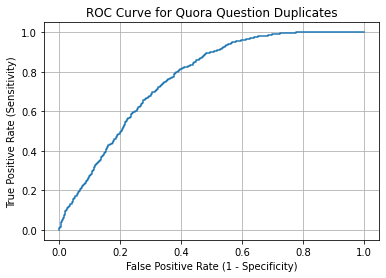


AUC Score : 0.7652807964753559


In [105]:
y_pred, y_pred_prob = train_model(linear_model.LogisticRegression(random_state = 99, max_iter=200), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## **Logistic Regression with L1 Regularization**

Accuracy Score : 0.702

Classification Report : 
              precision    recall  f1-score   support

           0       0.74      0.63      0.68      1246
           1       0.68      0.78      0.72      1254

    accuracy                           0.70      2500
   macro avg       0.71      0.70      0.70      2500
weighted avg       0.71      0.70      0.70      2500


Confusion Matrix : 
[[783 463]
 [282 972]]

Sensitivity (or recall) : 0.78
Specificity : 0.63
Precision : 0.68
False Positive Rate (FPR) : 0.37


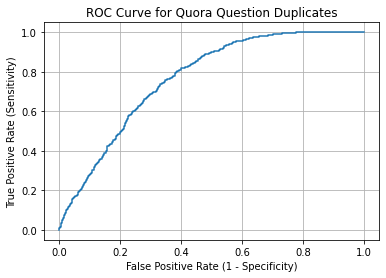


AUC Score : 0.7656174399225848


In [106]:
Cs = np.logspace(-2, 6, 9)
y_pred, y_pred_prob = train_model(linear_model.LogisticRegressionCV(Cs=Cs, penalty='l1', cv=10, solver='liblinear', random_state=99, max_iter=10000), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## **Logistic Regression with L2 Regularization**

Accuracy Score : 0.7004

Classification Report : 
              precision    recall  f1-score   support

           0       0.74      0.62      0.67      1246
           1       0.67      0.78      0.72      1254

    accuracy                           0.70      2500
   macro avg       0.71      0.70      0.70      2500
weighted avg       0.71      0.70      0.70      2500


Confusion Matrix : 
[[775 471]
 [278 976]]

Sensitivity (or recall) : 0.78
Specificity : 0.62
Precision : 0.67
False Positive Rate (FPR) : 0.38


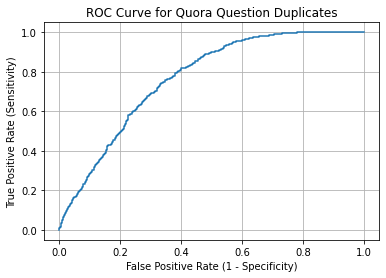


AUC Score : 0.7656872006369345


In [107]:
Cs = np.logspace(-2, 6, 9)
y_pred, y_pred_prob = train_model(linear_model.LogisticRegressionCV(Cs=Cs, penalty='l2', cv=10, random_state=99, max_iter=10000), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## Naive Bayes
A Naive Bayes classifier is a probabilistic machine learning model that’s used for classification task. The crux of the classifier is based on the Bayes theorem. Using Bayes theorem, we can find the probability of A happening, given that B has occurred. Here, B is the evidence and A is the hypothesis. The assumption made here is that the predictors/features are independent. That is presence of one particular feature does not affect the other. Hence it is called naive.

Accuracy Score : 0.6616

Classification Report : 
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1246
           1       0.66      0.67      0.66      1254

    accuracy                           0.66      2500
   macro avg       0.66      0.66      0.66      2500
weighted avg       0.66      0.66      0.66      2500


Confusion Matrix : 
[[820 426]
 [420 834]]

Sensitivity (or recall) : 0.67
Specificity : 0.66
Precision : 0.66
False Positive Rate (FPR) : 0.34


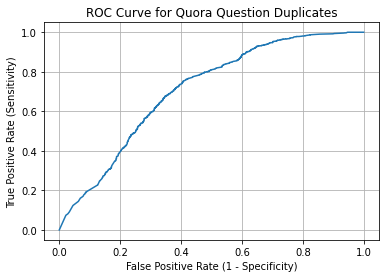


AUC Score : 0.7067041966509735


In [108]:
y_pred, y_pred_prob = train_model(naive_bayes.BernoulliNB(), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## SVM Classification
“Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However,  it is mostly used in classification problems. In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well.

Accuracy Score : 0.7056

Classification Report : 
              precision    recall  f1-score   support

           0       0.77      0.59      0.67      1246
           1       0.67      0.82      0.74      1254

    accuracy                           0.71      2500
   macro avg       0.72      0.71      0.70      2500
weighted avg       0.72      0.71      0.70      2500


Confusion Matrix : 
[[ 734  512]
 [ 224 1030]]

Sensitivity (or recall) : 0.82
Specificity : 0.59
Precision : 0.67
False Positive Rate (FPR) : 0.41


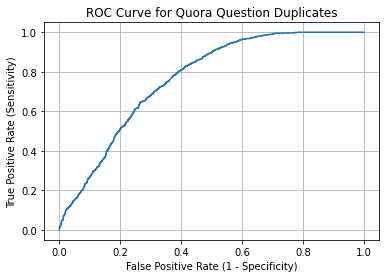


AUC Score : 0.7640161435253097


In [109]:
y_pred, y_pred_prob = train_model(svm.SVC(kernel='linear',random_state = 99, probability=True), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## Decision-Tree Classification
A decision tree is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome. The topmost node in a decision tree is known as the root node. It learns to partition on the basis of the attribute value. It partitions the tree in recursively manner call recursive partitioning. This flowchart-like structure helps you in decision making. It's visualization like a flowchart diagram which easily mimics the human level thinking.

Accuracy Score : 0.5816

Classification Report : 
              precision    recall  f1-score   support

           0       0.56      0.73      0.63      1246
           1       0.62      0.44      0.51      1254

    accuracy                           0.58      2500
   macro avg       0.59      0.58      0.57      2500
weighted avg       0.59      0.58      0.57      2500


Confusion Matrix : 
[[904 342]
 [704 550]]

Sensitivity (or recall) : 0.44
Specificity : 0.73
Precision : 0.62
False Positive Rate (FPR) : 0.27


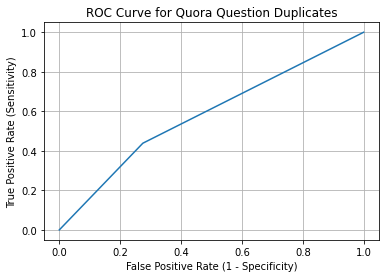


AUC Score : 0.5820590802849821


In [110]:
y_pred, y_pred_prob = train_model(tree.DecisionTreeClassifier(random_state = 99), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## Random-Forest Classification
Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

Accuracy Score : 0.7052

Classification Report : 
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      1246
           1       0.71      0.70      0.71      1254

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500


Confusion Matrix : 
[[880 366]
 [371 883]]

Sensitivity (or recall) : 0.70
Specificity : 0.71
Precision : 0.71
False Positive Rate (FPR) : 0.29


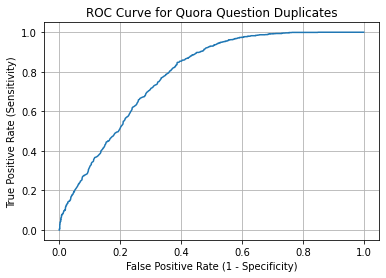


AUC Score : 0.7850480388919183


In [112]:
y_pred, y_pred_prob = train_model(ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state = 99), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

# Deep Neural Network Models

#### Defining 3 functions, each returning a different Keras model. 
#### The goal is to find out which of these 3 models leads to the lowest cross-validation error rate.

In [0]:
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
import numpy as np
from tensorflow import random

from keras.layers import Dense

# Create a function that returns the keras model 1
def build_model_1(activation='relu', optimizer='adam'):
  # create model 1  
  model = Sequential()
  model.add(Dense(18, input_dim=X_train.shape[1], activation=activation))
  model.add(Dense(18, activation=activation))
  model.add(Dense(18, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  # compile model 1
  model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
  return model

# Create a function that returns the keras model 2
def build_model_2(activation='relu', optimizer='adam'):
  # create model 2
  # print(f'Activation = {activation}  Optimizer={optimizer}')
  model = Sequential()
  model.add(Dense(18, input_dim=X_train.shape[1], activation=activation))
  model.add(Dense(9, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  # compile model 2
  model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
  return model

# Create a function that returns the keras model 3
def build_model_3(activation='relu', optimizer='adam'):
  # create model 3
  model = Sequential()
  model.add(Dense(18, input_dim=X_train.shape[1], activation=activation))
  model.add(Dense(9, activation=activation))
  model.add(Dense(6, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  # compile model 3
  model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
  return model
  



#### Writing code that will loop over the three models and perform 5-fold cross-validation.

In [114]:
# define a seed for random number generator so the result will be reproducible
seed = 99
np.random.seed(seed)
random.set_seed(seed)

# determine the number of folds for k-fold cross-validation, number of epochs and batch size
n_folds = 5
batch_size = 20
epochs = 100

# define the list to store cross-validation scores
results_1 = []

# define the possible options for the model
models =[build_model_1, build_model_2, build_model_3]

# loop over the models
for m in range(len(models)):
  # build the scikit-learn interface for the keras model
  classifier = KerasClassifier(build_fn=models[m], epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
  # define the cross-validation iterator
  kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
  # perform the k-fold cross-validation and store the scores in result
  result = cross_val_score(classifier, X_train, y_train, cv=kfold)
  # add the scores to the results list
  results_1.append(result)

# Print cross-validation score for each model
for m in range(len(models)):
  print("Model ", m+1, " cross-validation score = ", abs(results_1[m].mean()))


Model  1  cross-validation score =  0.6953333258628845
Model  2  cross-validation score =  0.7151999950408936
Model  3  cross-validation score =  0.7107999920845032


#### Choosing Model 2 as it has the highest cross-validation score. 
#### Repeating the above step by iterating over the epochs = [100, 200] and batches = [10, 20] values and performing 5-fold cross-validation

In [115]:
# define a seed for random number generator so the result will be reproducible
np.random.seed(seed)
random.set_seed(seed)

# determine the number of folds for k-fold cross-validation
n_folds = 5

# define the ossible options for epochs and batch_size
epochs = [100, 200]
batches = [10, 20]

# define the list to store cross-validation scores
results_2 = []

# loop over all possible pairs of epochs, batch_size
for e in range(len(epochs)):
  for b in range(len(batches)):
    # build the scikit-learn interface for the keras model
    classifier = KerasClassifier(build_fn=build_model_2, epochs=epochs[e], batch_size=batches[b], verbose=0)

    # define the corss-validation iterator
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # perform the k-fold cross-validation and store the scores in result
    result = cross_val_score(classifier, X_train, y_train, cv=kfold)

    # add the scores to the results list
    results_2.append(result)

# Print cross-validation score for each possible pair of epochs, batch_size
c = 0
for e in range(len(epochs)):
  for b in range(len(batches)):
    print("batch_size =", batches[b],", epochs =", epochs[e], ", Test Accuracy =", results_2[c].mean())
    c += 1

batch_size = 10 , epochs = 100 , Test Accuracy = 0.705733346939087
batch_size = 20 , epochs = 100 , Test Accuracy = 0.7113333225250245
batch_size = 10 , epochs = 200 , Test Accuracy = 0.7023999929428101
batch_size = 20 , epochs = 200 , Test Accuracy = 0.7030666589736938


##### Choosing the batch size and epochs with the highest accuracy score.
#### Repeating the above step by iterating over the optimizers = ['rmsprop', 'adam', 'sgd'] and activations = ['relu','tanh'] values and performing 5-fold cross validation

In [116]:
# define a seed for random number generator so the result will be reproducible
np.random.seed(seed)
random.set_seed(seed)

# determine the number of folds for k-fold cross-validation, number of epochs and batch size
n_folds = 5
batch_size = 20
epochs = 100

# define the list to store cross_validation scores
results_3 = []

# define possible options for optimizer and activation
optimizers = ['rmsprop', 'adam', 'sgd']
activations = ['relu','tanh']

# loop over all possible pairs of optimizer, activation
for o in range(len(optimizers)):
  for a in range(len(activations)):
    optimizer = optimizers[o]
    activation = activations[a]

    # build the scikit-learn interface for the keras model
    classifier = KerasClassifier(build_fn=build_model_2, activation=activation, optimizer=optimizer, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)

    # define the cross-validation iterator
    kfold = StratifiedKFold(n_splits = n_folds, shuffle=True, random_state=seed)

    # perform the k-fold cross-validation and store the scores in result
    result = cross_val_score(classifier, X_train, y_train, cv=kfold)

    # add the scores to the results list
    results_3.append(result)

# Print cross-validation score for each possible pair of optimizer, activation
c = 0
for o in range(len(optimizers)):
  for a in range(len(activations)):
    print("activation = ", activations[a],", optimizer = ", optimizers[o], ", Test accuracy = ", results_3[c].mean())
    c += 1

activation =  relu , optimizer =  rmsprop , Test accuracy =  0.712933337688446
activation =  tanh , optimizer =  rmsprop , Test accuracy =  0.7109333157539368
activation =  relu , optimizer =  adam , Test accuracy =  0.7129333257675171
activation =  tanh , optimizer =  adam , Test accuracy =  0.7075999975204468
activation =  relu , optimizer =  sgd , Test accuracy =  0.7097333312034607
activation =  tanh , optimizer =  sgd , Test accuracy =  0.7175999999046325


## Improving the Model Accuracy (L1, L2 and Dropout Regularization)
Regularization methods try to modify the learning algorithm in a way that reduces the variance of the mode. By decreasing the variance, regularization techniques intend to reduce the generalization error while not increasing the training error (or, at least, not increasing the training error drastically).

#### Model 2 with batch_size = 20 , epochs = 100, activation =  tanh , optimizer =  sgd has the best accuracy
#### Now let's see how the model behaves with regularization
#### Writing a function that returns the model 2 with the best hyperparameter values and takes l2 parameter as input and testing it for different valies of l2 parameter

In [0]:
from keras.regularizers import l1, l2, l1_l2

def build_model_2_l1l2(kernel_regularizer=None): 
  model_2 = Sequential()
  model_2.add(Dense(18, input_dim=X_train.shape[1], activation='tanh', kernel_regularizer=kernel_regularizer))
  model_2.add(Dense(9, activation='tanh', kernel_regularizer=kernel_regularizer))
  model_2.add(Dense(1, activation='sigmoid'))
  # compile model 3
  model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

  # fit the model to the training data to perform the classification while evaluating on the test set, 
  # saving the results of the training process
  history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

  # Plotting the trends in training error and test error by importing the necessary libraries for plotting the loss and
  # validation loss and saving them in the variable that was created when the model was fit to the training process. 
  # Printing out the maximum validation accuracy
  
 # plot training error and test error
  matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylim(0,1)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'], loc='upper right')

  # print the best accuracy reached on the test set
  print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
  print("Lowest error on Training Set =", min(history.history['loss']))
  print("Lowest error on Validation Set =", min(history.history['val_loss']))


#### Training the model with no regularization

Best Accuracy on Validation Set = 0.7164000272750854
Lowest error on Training Set = 0.5181392391522726
Lowest error on Validation Set = 0.5381243124008178


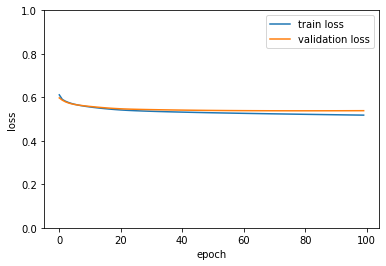

In [130]:
build_model_2_l1l2(kernel_regularizer=None)

## L2 Regularization
The most common type of regularization for deep learning models is the one that keeps the weights of the network small. This type of regularization is called weight regularization and has two difference variations: L2 regularization and L1 regularization.
In weight regularization, a penalizing term is added to the loss function. This term is either the L2 norm (the sum of the squared values) of the weights or the L1 norm (the sum of the absolute values) of the weights. If the L1 norm is used, then it will be called L1 regularizaiton. If the L2 norm is used, then it will be called L2 regularization.

#### Training the model by adding L2 regularizers with lambda=0.01 to each hidden layer of the model.

Best Accuracy on Validation Set = 0.7063999772071838
Lowest error on Training Set = 0.5553408869107564
Lowest error on Validation Set = 0.5580414431095123


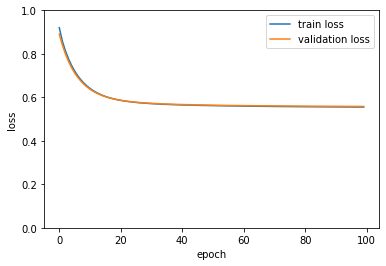

In [131]:
l2_param = 0.01
build_model_2_l1l2(kernel_regularizer=l2(l2_param))

As seen from the preceding plots, the test error almost plateaus after being decreased to a certain amount. The gap between the training error and the validation error at the end of the training process (the bias) is very small, which is indicative of reduced overfitting (low variance) of the model for the training examples. This is good.

#### Training the model by adding L2 regularizers with lambda=0.1 to each hidden layer of the model.

In [ ]:
l2_param = 0.1
build_model_2_l1l2(kernel_regularizer=l2(l2_param))

The training and validation error quickly plateau and are much higher than they were for the model that was created with a lower L2 parameter, indicating that we have penalized the model so much that it has not had the flexibility to learn the underlying function of the training data. Following this, we will reduce the valie of the regularization parameter to prevent it from penalizing the model as much.

#### Repeating the previous step with lambda=0.005 for the L2 parameter.

Best Accuracy on Validation Set = 0.7111999988555908
Lowest error on Training Set = 0.5471064503192902
Lowest error on Validation Set = 0.551440169095993


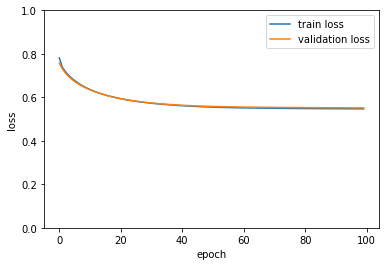

In [135]:
l2_param = 0.005
build_model_2_l1l2(kernel_regularizer=l2(l2_param))

The value for the L2 weight regularization achieves the second highest accuracy that was evaluated on the validation data of all models with L2 regularization. Again, the test error doesn't increase a significant amount after being decreased to a certain value, which is indicative of the model not overfitting the training examples. It seems that L2 weight regularization with lambda=0.005 achieves the lowest validation error while preventing the model from overfitting.

## **L1 Regularization**

#### Repeating the previous step with lambda=0.01 for the L1 parameter.

Best Accuracy on Validation Set = 0.6984000205993652
Lowest error on Training Set = 0.5767499401569366
Lowest error on Validation Set = 0.5810464961528778


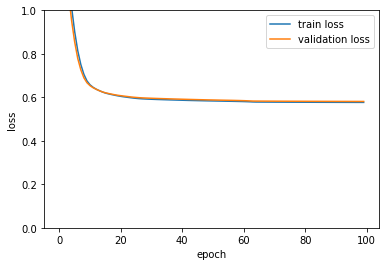

In [138]:
l1_param = 0.01
build_model_2_l1l2(kernel_regularizer=l1(l1_param))

#### Repeating the previous step with lambda=0.005 for the L1 parameter.

Best Accuracy on Validation Set = 0.699999988079071
Lowest error on Training Set = 0.5732855691115062
Lowest error on Validation Set = 0.5756369619369507


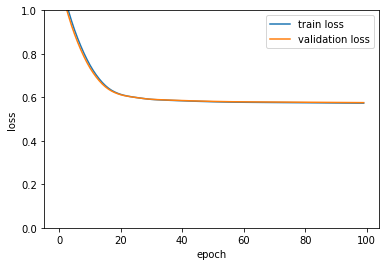

In [141]:
l1_param = 0.005
build_model_2_l1l2(kernel_regularizer=l1(l1_param))

It seems that L1 weight regularization with lamda=0.005 achieves a better test error while preventing a model from overfitting since the value of lambda=0.01 is too restrictive and prevents the model from learning the underlying function of the training data.

#### Repeating the previous step with L1 and L2 regularizers with an L1 of lambda=0.005 and an L2 of lambda=0.005 to the hidden layers of the model.

Best Accuracy on Validation Set = 0.6988000273704529
Lowest error on Training Set = 0.5736499591668447
Lowest error on Validation Set = 0.5775598077774048


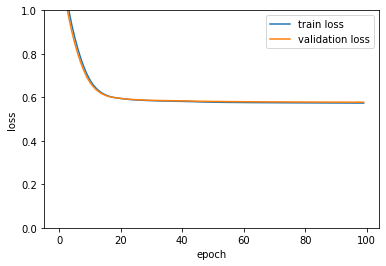

In [143]:
l1_param = 0.005
l2_param = 0.005
build_model_2_l1l2(kernel_regularizer=l1_l2(l1=l1_param, l2=l2_param))

While L1 and L2 regularization are successful in preventing the model from overfitting, the variance in the model is very low. However, the accuracy that's obtained on the validaton set is not as high as the model that was trained with no regularization or the model that was trained with the L2 regularization lambda=0.005 or L1 regularization lambda = 0.005 parameter individually.

## Dropout Regularization
Dropout regularization works by randomly removing nodes from a neural network during training. More precisely, dropout sets up a probability on each node. This probability referes to the chance that the node is included in the training at each iteration of the learning algorithm. Evaluation, however, is always performed on the original network


Model 2 : batch_size = 20 , epochs = 100, activation =  tanh , optimizer =  sgd<br/>
Now let's see how the model behaves with dropout regularization

#### Redefining Model 2 by creating the same model architecture
#### Adding a dropout regularization with rate = 0.1 to the first hidden layer of the model.
#### Repeating the steps to train the model on the training data and to plot the trends for the training and validation errors.
#### Printing the best accuracy that was reached on the validation set.

Best Accuracy on Validation Set = 0.7156000137329102
Lowest error on Training Set = 0.5315577251911163
Lowest error on Validation Set = 0.5365328528881073


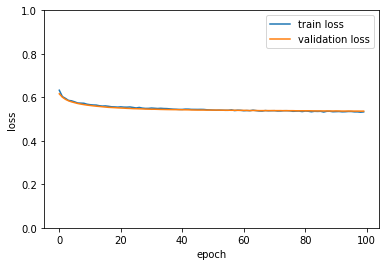

In [145]:
from keras.layers import Dropout

# create model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='tanh'))
model_2.add(Dropout(0.1))
model_2.add(Dense(9, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))
# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
# train the model using training set while evaluating on the test set
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

# print the best accuracy reached on the test set
print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

There is a very small gap between the training error and the validation error. The validation error is slightly higher than
the training error, indicating that the model is might be overfitting the training data.

#### Repeating the previous step, this time adding dropout regularization with rate=0.1 to all hidden layers of the model.
#### Repeating the steps to train the model on the training data and plot the trends for the training and validation errors.

Best Accuracy on Validation Set = 0.7135999798774719
Lowest error on Training Set = 0.5407212632497151
Lowest error on Validation Set = 0.5382600486278534


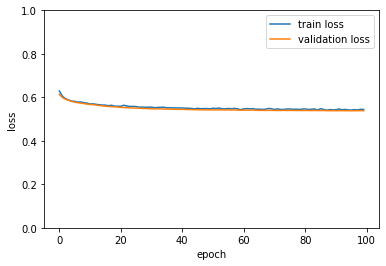

In [147]:
# create model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='tanh'))
model_2.add(Dropout(0.1))
model_2.add(Dense(9, activation='tanh'))
model_2.add(Dropout(0.1))
model_2.add(Dense(1, activation='sigmoid'))
# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
# train the model using training set while evaluating on the test set
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

# print the best accuracy reached on the test set
print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

The training error has increased as a result of additional regularization on the other 2 hidden layers of the model.

#### Repeating the previous step, this time adding dropout regularization with rate=0.2 to the first layer and rate=0.1 to the rest of the hidden layers
#### Repeating the steps to train the model on the training data and plot the trends for the training and validation errors.

Best Accuracy on Validation Set = 0.7111999988555908
Lowest error on Training Set = 0.5476378169059753
Lowest error on Validation Set = 0.5414268429279327


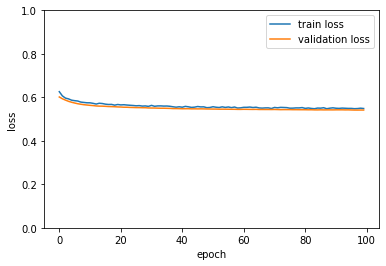

In [149]:
# create model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='tanh'))
model_2.add(Dropout(0.2))
model_2.add(Dense(9, activation='tanh'))
model_2.add(Dropout(0.1))
model_2.add(Dense(1, activation='sigmoid'))
# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
# train the model using training set while evaluating on the test set
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

# print the best accuracy reached on the test set
print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

The gap between the training error and validation error is slightly larger due to the increase in regularization. In this case, there was no overfitting in the original model. As a result, regularization increased the error rate on the training and validation dataset.

## Early Stopping
By monitoring the training process, we can train the model just enough for it to capture the form of the process, and we can stop the training right before it starts to overfit to individual data examples. This means forcing the Keras model to stop the training when a desired metric e.g. test error rate is not improving anymore.

#### Recreating the base model

Best Accuracy on Validation Set = 0.72079998254776
Lowest error on Training Set = 0.5150706218878428
Lowest error on Validation Set = 0.5370968613624573


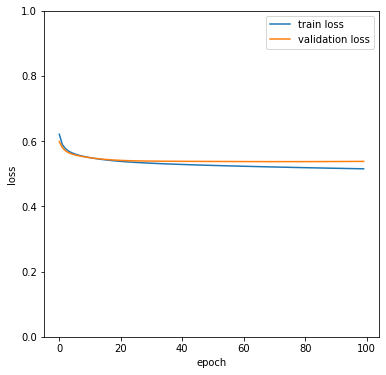

In [151]:
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='tanh'))
model_2.add(Dense(9, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))

# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

# train the model
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

From the preceding plot, we can see that the training the model for 100 epochs results in a gap that grows between the training error and validation error, which is indicative of overfitting beginning to happen.

#### Redefining the model exactly the same way and adding a callback to the training process

Best Accuracy on Validation Set = 0.7192000150680542
Lowest error on Training Set = 0.5166841110388438
Lowest error on Validation Set = 0.5350715706348419


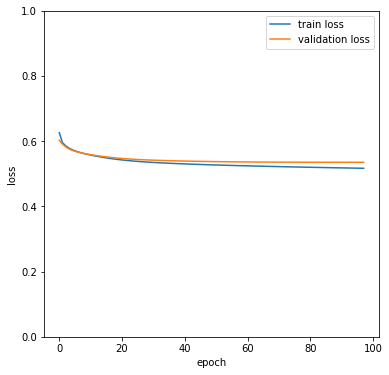

In [153]:
from keras.callbacks import EarlyStopping
# Recreate the base model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='tanh'))
model_2.add(Dense(9, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))

# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

# define early stopping callback
# since the metric is error/loss, we would like to minimize it
es_callback = EarlyStopping(monitor='val_loss', mode='min')

# train the model
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), callbacks=[es_callback], verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

By adding the early stopping callback with patience=0 to the model, the training process automatically stops after about 65 epochs. If there are a lot of fluctuations or noise in the error rates, it is probably NOT a good idea to stop the training immediately when the loss begins to increase. For this reason, we can set the patience argument to a number  of epochs to give the early stopping method some time to monitor the desired metric for longer before stopping the training process.

#### Redefining the model and adding a callback with patience=10 to the training process

Best Accuracy on Validation Set = 0.7228000164031982
Lowest error on Training Set = 0.5202365859349569
Lowest error on Validation Set = 0.5352703838348388


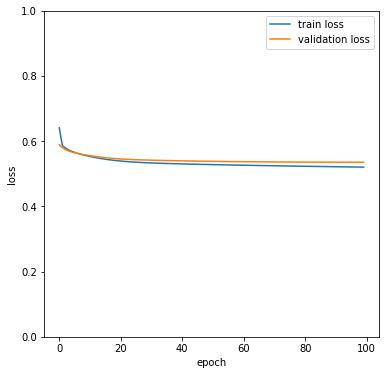

In [155]:
from keras.callbacks import EarlyStopping
# Recreate the base model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='tanh'))
model_2.add(Dense(9, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))

# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

# define early stopping callback
# since the metric is error/loss, we would like to minimize it
es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=10)

# train the model
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), callbacks=[es_callback], verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

By adding the early stopping callback with patience=10 to the model, the training process automatically stops after about 85 epochs.

## Hyperparameter Tuning with scikit-learn
The process of training and evaluating models with different hyperparameters and deciding about the final hyperparameters based on model performance is called hyperparameter tuning or hyperparameter optimization.

#### Recreating the function that returns the keras model with regularization

In [0]:
def build_model_2(lambda_parameter): 
  model_2 = Sequential()
  model_2.add(Dense(18, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(lambda_parameter)))
  model_2.add(Dense(9, activation='relu', kernel_regularizer=l2(lambda_parameter)))
  model_2.add(Dense(1, activation='sigmoid'))
  # compile model 3
  model_2.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

#### Setting a seed, using a scikit-learn wrapper to wrap the model that was created in the previous step, and define the hyperparameters to scan. Finally, performing GridSearchCV() on the model using the hyperparameter's grid and fitting the model

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l2
# define a seed for random number generator so the result will be reproducible
seed = 99
np.random.seed(seed)
random.set_seed(seed)

# define all the possible values for each hyperparameter
lambda_parameter = [0.01, 0.5, 1]
epochs = [50, 100]
batch_size = [20]

# create the Keras wrapper with scikit learn
model = KerasClassifier(build_fn=build_model_2, verbose=0, shuffle=False)

print(model.loss)

# create the dictionary containing all possible values of hyperparameters
param_grid = dict(lambda_parameter=lambda_parameter, epochs=epochs, batch_size=batch_size)

# perform 5-fold cross-validation for the model and store the results
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

results_1 = grid_search.fit(X_train, y_train)

# Print the results for the best cross-valiation score that's stored within
# the variable that was created in the fit process. Iterate through all the parameters
# and print the mean of the accuracy across all the folds, the standard deviation
# of the accuracy and the parameters themselves.

print("Best cross-validation score =", results_1.best_score_)
print("Parameters for Best cross-validation score =", results_1.best_params_)

# print the results for all evaluated hyperparameter combinations
accuracy_means = results_1.cv_results_['mean_test_score']
accuracy_stds = results_1.cv_results_['std_test_score']
parameters = results_1.cv_results_['params']

for p in range(len(parameters)):
  print("Accuracy %f (std %f) for params %r" % (accuracy_means[p], accuracy_stds[p], parameters[p]))

## Deep Neural Network with Pre-Trained GloVe Embedding
A word embedding is a class of approaches for representing words and documents using a dense vector representation. It is an improvement over more the traditional bag-of-words model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.
Two popular examples of methods of learning word embeddings from text are : Word2Vec and GloVe

In [166]:
# Combine q1 and q2 columns
df['q1_q2_combined'] = df.question1.str.cat(df.question2,sep=" ")
df.head()

docs = df.q1_q2_combined.to_list()
labels = df.is_duplicate.to_list()
docs[0]

from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# print(encoded_docs)

# pad documents to a max length = questions with highest number of words q1+q2
max_length = max([len(s.split()) for s in docs])
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# print(padded_docs)

# load the whole embedding into memory
embeddings_index = dict()
f = open('drive/My Drive/Colab Notebooks/glove.6B.100d.txt', mode='rt', encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector


Loaded 400000 word vectors.


#### Defining 3 functions, each returning a different Keras model. The goal is to find out which of these 3 models leads to the lowest cross-validation error rate.

In [0]:
# Create a function that returns the keras model 1
def build_model_1(activation='tanh', optimizer='adam'):
  # create model 1  
  model = Sequential()
  e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
  model.add(e)
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Create a function that returns the keras model 2
def build_model_2(activation='tanh', optimizer='adam'):
  # create model 2  
  model = Sequential()
  e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
  model.add(e)
  model.add(Flatten())
  model.add(Dense(50, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  # compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Create a function that returns the keras model 3
def build_model_3(activation='tanh', optimizer='adam'):
  # create model 3
  model = Sequential()
  e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
  model.add(e)
  model.add(Flatten())
  model.add(Dense(50, activation=activation))
  model.add(Dense(25, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  # compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

#### Writing code that will loop over the three models and perform 5-fold cross-validation. 

In [163]:
from tensorflow import random
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

#defining a seed for random number generator so the result will be reproducible
seed = 99
np.random.seed(seed)
random.set_seed(seed)

# determine the number of folds for k-fold cross-validation, number of epochs and batch size
n_folds = 5
batch_size = 20
epochs = 50

# define the list to store cross-validation scores
results_1 = []

# define the possible options for the model
models =[build_model_1, build_model_2, build_model_3]

# loop over the models
for m in range(len(models)):
  # build the scikit-learn interface for the keras model
  classifier = KerasClassifier(build_fn=models[m], epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
  # define the cross-validation iterator
  kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
  # perform the k-fold cross-validation and store the scores in result
  result = cross_val_score(classifier, padded_docs, labels, cv=kfold)
  # add the scores to the results list
  results_1.append(result)
  # Print cross-validation score for each model
  print("Model ", m+1, " cross-validation score = ", abs(results_1[m].mean()))

Model  1  cross-validation score =  0.5130999922752381
Model  2  cross-validation score =  0.5001999974250794
Model  3  cross-validation score =  0.5055999994277954


#### Adding a Convolutional Layer to the GloVe Embedding Model above

In [165]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
def build_model_2(activation='tanh', optimizer='adam'):
  # create model 2  
  model = Sequential()
  e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
  model.add(e)
  model.add(Conv1D(filters=32, kernel_size=8, activation=activation))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  # compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model


# build the scikit-learn interface for the keras model
classifier = KerasClassifier(build_fn=build_model_2, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
# define the cross-validation iterator
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
# perform the k-fold cross-validation and store the scores in result
result = cross_val_score(classifier, padded_docs, labels, cv=kfold)
# add the scores to the results list
results_1.append(result)
# Print cross-validation score for each model
print("Cross-validation score = ", abs(results_1[m].mean()))

Cross-validation score =  0.5055999994277954


## Summary

<img src='Summary.png'>